In [15]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm 

In [16]:
df = pd.read_csv('../data/canada/listings.csv')

In [17]:
df.info()
#13621 observation and 18 variables
#note the neighbourhood_group has al it entries as null value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13621 entries, 0 to 13620
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13621 non-null  int64  
 1   name                            13617 non-null  object 
 2   host_id                         13621 non-null  int64  
 3   host_name                       13620 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   13621 non-null  object 
 6   latitude                        13621 non-null  float64
 7   longitude                       13621 non-null  float64
 8   room_type                       13621 non-null  object 
 9   price                           13621 non-null  int64  
 10  minimum_nights                  13621 non-null  int64  
 11  number_of_reviews               13621 non-null  int64  
 12  last_review                     

In [27]:
#dropping the neighbourhood_group 
df.drop('neighbourhood_group', axis =1, inplace=True)

In [19]:
#512 differnt licenses 
len(df.license.unique()) ,df.license.unique()


(512,
 array([nan, '261 026', '305995', '271530', '310728', '249454',
        '735374308RT0001', '307546', '310331',
        'Numéro établissement CITQ :\xa0263966', '221373', '1169743656',
        '266641', '263141', '257530', '306072', '301568', '308396',
        '307397', '299969', '303664', '308905', 'CITQ:267234', '286775',
        '307396', '301286', 'CITQ#304975', '304909', '281470', '306732',
        '304615', '306955', '281282', '299353', '274201', '303170',
        'No CITQ: 305895', '275601', '230370', '301128', '307763',
        '300651', '307822', '309323', '297531', '303164', 'Citq305642',
        '302264', 'CITQ # 247671', 'CITQ # 272241', 'CITQ # 279355',
        '289785', '307329', '218105', '279300', '305171', '222528',
        '308163', 'CITQ # 286731', '277922', '280350', '310063',
        'CITQ # 286720', '279915', '308907', 'CITQ 282262', 'CITQ:#309495',
        '286904', '308210', '302655', 'CITQ # 292353', '296323', '295699',
        '294243', 'CITQ # 309935', '

In [28]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,1.362100e+04,1.362100e+04,13621.000000,13621.000000,13621.000000,13621.000000,13621.000000,11047.000000,13621.000000,13621.000000,13621.000000
mean,1.663965e+17,1.496673e+08,45.514491,-73.591639,169.029073,15.623523,23.994200,1.498029,10.141473,128.566405,8.402760
std,2.833332e+17,1.459350e+08,0.032831,0.051336,958.044866,108.486987,49.724181,1.873254,24.852071,133.881257,16.396578
min,2.843000e+03,2.319000e+03,45.382600,-73.974520,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.179813e+07,2.497750e+07,45.495850,-73.604150,65.000000,1.000000,1.000000,0.160000,1.000000,0.000000,0.000000
50%,3.950434e+07,9.503213e+07,45.516270,-73.578870,109.000000,2.000000,6.000000,0.730000,2.000000,79.000000,1.000000
75%,5.516946e+17,2.419049e+08,45.532630,-73.564110,176.000000,21.000000,24.000000,2.210000,6.000000,258.000000,9.000000
max,7.137874e+17,4.789758e+08,45.713800,-73.481630,105634.000000,11684.000000,734.000000,24.730000,183.000000,365.000000,251.000000


In [50]:
df.dtypes
#id, id_host are int variabe,most likely they are not used in graph or any mathematical operation
#I will change them to string type.
df['id'] = df['id'].astype(str)
df['host_id'] = df['host_id'].astype(str)
df.dtypes

id                                 object
name                               object
host_id                            object
host_name                          object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object

7

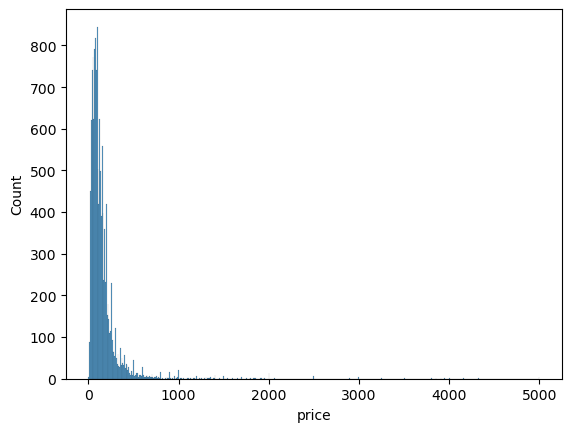

In [43]:
#The variation in price is high, the distribution of prices is:
sns.histplot( x= 'price', 
data = df, 
binrange=[0,5000])
#The histogram here shows the range from [0, 5000], the number of data not included 
#in the histogram is: 7
df[df['price'] > 5000].count()['price']
#The distribution of price seems to be right skewed. 

In [90]:
#the mean and standard deviation price for each room type
df.groupby(['room_type']).agg({'price': ['mean', 'std', 'count']})
#.plot(kind = 'bar')

price                    
                       mean          std  count
room_type                                      
Entire home/apt  182.132282   315.459394  10523
Hotel room       180.027027    88.415838     37
Private room     124.862922  1956.371146   2991
Shared room       80.585714   155.046650     70

In [95]:
len(df.neighbourhood.unique()), df.neighbourhood.unique()
# 33 neightbourhoods 

(33,
 array(['Le Plateau-Mont-Royal', 'Le Sud-Ouest',
        'Villeray-Saint-Michel-Parc-Extension', 'Ville-Marie',
        'Rosemont-La Petite-Patrie', 'LaSalle',
        'Mercier-Hochelaga-Maisonneuve',
        'Côte-des-Neiges-Notre-Dame-de-Grâce', 'Montréal-Ouest', 'Verdun',
        "Baie-d'Urfé", 'Lachine', 'Côte-Saint-Luc',
        'Ahuntsic-Cartierville', 'Saint-Laurent', 'Outremont',
        'Pierrefonds-Roxboro', 'Saint-Léonard', 'Anjou',
        'Rivière-des-Prairies-Pointe-aux-Trembles', 'Pointe-Claire',
        'Mont-Royal', 'Dollard-des-Ormeaux', 'Hampstead', 'Dorval',
        'Westmount', 'Kirkland', "L'Île-Bizard-Sainte-Geneviève",
        'Montréal-Nord', 'Beaconsfield', 'Sainte-Anne-de-Bellevue',
        'Montréal-Est', 'Senneville'], dtype=object))

In [106]:
df.neighbourhood.value_counts()
#most hosts are in ville-Marie.

Ville-Marie                                 4061
Le Plateau-Mont-Royal                       3081
Rosemont-La Petite-Patrie                   1102
Le Sud-Ouest                                1025
Côte-des-Neiges-Notre-Dame-de-Grâce         1009
Mercier-Hochelaga-Maisonneuve                754
Villeray-Saint-Michel-Parc-Extension         612
Ahuntsic-Cartierville                        457
Verdun                                       293
Saint-Laurent                                184
LaSalle                                      132
Outremont                                    129
Lachine                                      102
Pierrefonds-Roxboro                           69
Rivière-des-Prairies-Pointe-aux-Trembles      61
Westmount                                     61
Saint-Léonard                                 57
Montréal-Nord                                 55
Anjou                                         53
Côte-Saint-Luc                                51
Mont-Royal          

In [110]:
#describtive statistic on minimum_nights 
df.minimum_nights.describe()
# the minimum of the minimum number of night is 1, while the maximum is 11684 nights !!
# lets investigate this maximum number. 

count    13621.000000
mean        15.623523
std        108.486987
min          1.000000
25%          1.000000
50%          2.000000
75%         21.000000
max      11684.000000
Name: minimum_nights, dtype: float64

438

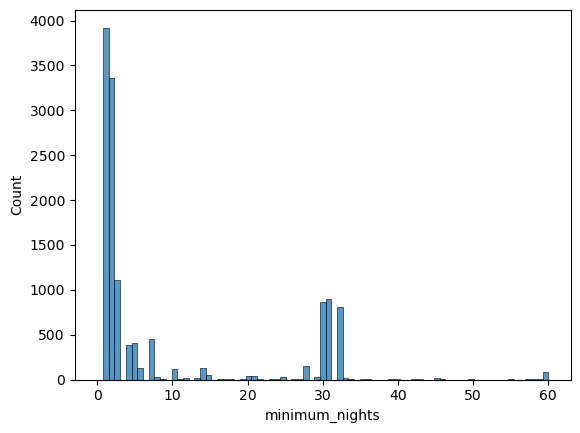

In [124]:
#The distribution of minimum nights 
#showing only up to two months, 
sns.histplot(x= 'minimum_nights', data = df, binrange=[0,60])
#the number of observation not included in the histogram is 438
df[df['minimum_nights'] > 60].count()['minimum_nights']

In [119]:
#what is the row number with minimum night of 11684 nights
df[df['minimum_nights'] > 11600]
#only had one listing, last review was on 22-08-2017

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
2765,19906947,"Charming apartment beside river, near downtown!!",81742896,Sjsj,Le Sud-Ouest,45.47828,-73.5729,Private room,100,11684,2,2017-08-22,0.03,1,0,0,NaN


In [133]:
#lets see the host other listings
df.iloc[2765]['id']
df[df['host_id'] == df.iloc[2765]['host_id']]
#only have this listing 


,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
2765,19906947,"Charming apartment beside river, near downtown!!",81742896,Sjsj,Le Sud-Ouest,45.47828,-73.5729,Private room,100,11684,2,2017-08-22,0.03,1,0,0,NaN


In [138]:
import geopandas as gpd
import folium
import shapely
import plotly.express as px
geo_df = gpd.GeoDataFrame(df, 
geometry= gpd.points_from_xy(df['latitude'], df['longitude']))

In [140]:
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ImportError: The 'read_file' function requires the 'pyogrio' or 'fiona' package, but neither is installed or imports correctly.
Importing fiona resulted in: libtiledb.so.2.2: cannot open shared object file: No such file or directory
Importing pyogrio resulted in: No module named 'pyogrio'